# Лабораторная работа №2: мета-обучение

`Создание набора данных`
1) Скачайте архив с наборами данных для задачи классификации или изучите API сайта OpenML.
При необходимости сформулируйте набор критериев для фильтрации наборов данных и исключите неподходящие датасеты (например, слишком долгая обработка, низкое качество данных и т.д.). Минимальное количество наборов данных - 300.
2) Реализуйте по несколько мета-признаков из каждой группы: базовые, статистический и структурные
3) Выберите один набор данных. Измените в нем порядок строк, столбцов и категорий при наличии категориальных признаков. Опишите, как изменились мета-признаки.
4) Выберите не менее трех алгоритмов обучения с учителем и меру оценки алгоритма обучения (валидацию)
5) Постройте мета-набор данных. Для каждого набора данных обучите каждый из выбранных ранее алгоритмов и определите наилучший. Если мета-набор данных получился сильно несбалансированным, попробуйте использовать другие алгоритмы или гиперпараметры алгоритмов обучения. Но не стоит настраивать гиперпараметры под каждый набор данных. В результате у вас должен получиться набор данных, где каждый пример - это датасет, его признаки это мета-признаки, а таргет - индекс лучшего алгоритма.
6) Определите в мета-наборе данных попарную корреляцию мета-признаков. Если обнаружите пары с высокой корреляцией, объясните причины такого поведения и исключите лишние признаки в дальнейших шагах.
Визуализируйте мета-набор данных проекцией на двумерном графике. Используйте разные цвета для разных мета-классов.  
  

`Сравнение поведения алгоритмов`  
1) Протестируйте несколько алгоритмов обучения с учителем (включая наивный алгоритм) на полученном наборе данных. Алгоритмы обучения могут отличаться от используемых на 5-м шаге алгоритмов. Также можно использовать другие гиперпараметры для них.
2) Для одного выбранного алгоритма проведите обучение для случаев с полным набором мета-признаков, а также для случаев в отсутствием признаков каждой из групп по отдельности (базовые, статистические, структурные). Сравните полученные метрики и объясните, подкрепив рассуждения графиками, полученные результаты.
3) Выбрав один набор данных из мета-набора и любой из обученных ранее алгоритмов, добавьте в данные шум, измените метки целевого класса и категориальные признаки. Пересчитав метапризнаки, получите новое предсказание от алгоритма. Объясните изменение метапризнаков и новое предсказание.


In [1]:
LOADED = True

In [2]:
import openml, pandas as pd, numpy as np, time, os, json
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# Критерии фильтрации
MIN_ROWS, MAX_ROWS = 200, 50000
MIN_COLS, MAX_COLS = 4, 80
MAX_CLASSES = 30
MAX_MISSING_RATIO = 0.2
MAX_FETCH = 5000  


if not LOADED:
    # Поиск задач классификации на OpenML
    tasks = openml.tasks.list_tasks(output_format='dataframe')
    clf_tasks = tasks[(tasks['task_type'] == 'Supervised Classification')]
    clf_tasks = clf_tasks.head(MAX_FETCH)

    selected = []
    for _, row in clf_tasks.iterrows():
        did = int(row['did'])
        try:
            ds = openml.datasets.get_dataset(did)
            info = ds.get_data(dataset_format='dataframe', target=row['target_feature'])
            X, y, categorical, attr = info[0], info[1], info[2], info[3]
            n, m = X.shape
            if not (MIN_ROWS <= n <= MAX_ROWS and MIN_COLS <= m <= MAX_COLS):
                continue
            n_classes = len(pd.Series(y).dropna().unique())
            
            if n_classes < 2 or n_classes > MAX_CLASSES:
                continue
            missing_ratio = float(X.isna().mean().mean())
            if missing_ratio > MAX_MISSING_RATIO:
                continue
            selected.append(dict(did=did, name=ds.name, n=n, m=m, n_classes=n_classes, missing_ratio=missing_ratio))
        except Exception as e:
            continue

    sel_df = pd.DataFrame(selected).drop_duplicates('did')
    sel_df = sel_df.head(500)
    print('Selected candidates:', len(sel_df))
    sel_df.to_csv('data/selected_datasets.csv', index=False)
else:
    sel_df = pd.read_csv('data/selected_datasets.csv')

### Вычисляем мета-признаки

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import is_datetime64tz_dtype as _is_dt_tz
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

MAX_ROWS_FOR_LM = 5000
MAX_COLS_FOR_LM = 200
DEFAULT_CV = 5
RANDOM_STATE = 0


def _ohe_compat():
    return OneHotEncoder(handle_unknown='ignore', sparse_output=False)

def _is_any_datetime(obj) -> bool:
    try:
        return  _is_dt_tz(obj)
    except Exception:
        return False


def _coerce_datetimes_to_string(X: pd.DataFrame) -> pd.DataFrame:
    dt_cols = [c for c in X.columns if _is_any_datetime(X[c])]
    if dt_cols:
        X = X.copy()
        X[dt_cols] = X[dt_cols].astype('string')
    return X


def _sanitize_Xy(X: pd.DataFrame, y: pd.Series):
    y = pd.Series(y).copy()
    mask = ~y.isna()
    X = X.loc[mask].copy()
    y = y.loc[mask].copy()

    X = _coerce_datetimes_to_string(X)

    X = X.dropna(axis=1, how="all")
    nunique = X.nunique(dropna=True)
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        X = X.drop(columns=const_cols)

    return X, y


def _split_cols(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    return num_cols, cat_cols


def _cap_Xy(X, y, max_rows=MAX_ROWS_FOR_LM, max_cols=MAX_COLS_FOR_LM, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    Xs, ys = X, y
    if len(Xs) > max_rows:
        idx = rng.choice(len(Xs), size=max_rows, replace=False)
        Xs = Xs.iloc[idx]
        ys = ys.iloc[idx]
    if Xs.shape[1] > max_cols:
        cols = rng.choice(Xs.columns, size=max_cols, replace=False)
        Xs = Xs.loc[:, cols]
    return Xs, ys


def _onehot_preprocessor(X: pd.DataFrame, with_scaler=False):
    num_cols, cat_cols = _split_cols(X)
    num_steps = [('imp', SimpleImputer(strategy='median'))]
    if with_scaler and len(num_cols) > 0:
        num_steps.append(('sc', StandardScaler(with_mean=True)))
    num_pipe = Pipeline(num_steps)

    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', _ohe_compat())
    ])

    transformers = []
    if len(num_cols) > 0:
        transformers.append(('num', num_pipe, num_cols))
    if len(cat_cols) > 0:
        transformers.append(('cat', cat_pipe, cat_cols))
    if not transformers:
        transformers = [('num', num_pipe, [])]

    return ColumnTransformer(transformers=transformers, remainder='drop')


def _adaptive_cv(y, desired=DEFAULT_CV):
    y = pd.Series(y)
    vc = y.value_counts(dropna=False)
    if vc.shape[0] < 2:
        return None, 0  # недостаточно классов
    min_class = int(vc.min())
    if min_class < 2:
        return None, 0  # нельзя делать стратифицированный CV
    n_splits = max(2, min(desired, min_class))
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE), n_splits


# МЕТА-ПРИЗНАКИ

def basic_meta(X, y):
    n_samples, n_features = X.shape
    n_classes = len(pd.Series(y).dropna().unique())
    # доля категориальных
    dtypes = X.dtypes.astype(str)
    frac_cat = float(((dtypes == 'object') | (dtypes == 'string')).mean())
    return dict(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        frac_categorical=frac_cat,
        ratio_samples_per_feature=n_samples / max(1, n_features)
    )


def column_agg(x: pd.Series):
    s = pd.to_numeric(x, errors='coerce')
    s = s.replace([np.inf, -np.inf], np.nan)
    return pd.Series({
        'min': np.nanmin(s.values),
        'max': np.nanmax(s.values),
        'mean': np.nanmean(s.values),
        'std': np.nanstd(s.values),
        'skew': pd.Series(s).skew(skipna=True),
        'kurt': pd.Series(s).kurt(skipna=True),
    })


def statistical_meta(X: pd.DataFrame):
    num = X.select_dtypes(include=[np.number])
    if num.shape[1] == 0:
        # если числовых признаков нет — NaN
        return {f'col_{s}_{a}': np.nan for s in ['min', 'max', 'mean', 'std', 'skew', 'kurt'] for a in ['mean', 'std']}
    per_col = num.apply(column_agg, axis=0)
    out = {}
    for stat in per_col.index:
        vals = per_col.loc[stat].values.astype(float)
        out[f'col_{stat}_mean'] = float(np.nanmean(vals))
        out[f'col_{stat}_std'] = float(np.nanstd(vals))
    return out


def structural_meta_decision_tree(X: pd.DataFrame, y, random_state=RANDOM_STATE):
    Xc, yc = _sanitize_Xy(X, pd.Series(y))
    if pd.Series(yc).nunique(dropna=True) < 2 or Xc.shape[1] == 0 or Xc.shape[0] < 2:
        return dict(tree_node_count=np.nan, tree_leaf_count=np.nan,
                    tree_depth_max=np.nan, tree_leaf_depth_mean=np.nan)

    pre = _onehot_preprocessor(Xc, with_scaler=False)
    model = Pipeline([
        ('pre', pre),
        ('clf', DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=random_state))
    ])
    model.fit(Xc, yc)
    ### пишем небольшой алгоритм обхода дерева
    clf = model.named_steps['clf']
    t = clf.tree_
    n_nodes = int(t.node_count)
    left, right = t.children_left, t.children_right

    depth = np.zeros(shape=n_nodes, dtype=int)
    stack = [(0, 0)]
    leaf_depths = []
    while stack:
        node, d = stack.pop()
        depth[node] = d
        if left[node] == -1 and right[node] == -1:
            leaf_depths.append(d)
        else:
            stack.append((left[node], d + 1))
            stack.append((right[node], d + 1))

    return dict(
        tree_node_count=n_nodes,
        tree_leaf_count=int(len(leaf_depths)),
        tree_depth_max=int(depth.max() if n_nodes else 0),
        tree_leaf_depth_mean=float(np.mean(leaf_depths)) if leaf_depths else np.nan
    )


def landmarkers(X: pd.DataFrame, y, random_state=RANDOM_STATE):
    Xc, yc = _sanitize_Xy(X, pd.Series(y))
    if pd.Series(yc).nunique(dropna=True) < 2 or Xc.shape[0] < 2 or Xc.shape[1] == 0:
        return {k: np.nan for k in ['dummy_mf_acc_mean', 'gnb_acc_mean', 'linsvc_acc_mean',
                                    'logreg_acc_mean', 'knn5_acc_mean', 'dt_acc_mean']}

    Xs, ys = _cap_Xy(Xc, yc, random_state=random_state)
    pre_scaled = _onehot_preprocessor(Xs, with_scaler=True)
    pre_no_scale = _onehot_preprocessor(Xs, with_scaler=False)

    cv, _ = _adaptive_cv(ys)
    if cv is None:
        return {k: np.nan for k in ['dummy_mf_acc_mean', 'gnb_acc_mean', 'linsvc_acc_mean',
                                    'logreg_acc_mean', 'knn5_acc_mean', 'dt_acc_mean']}

    algos = {
        'dummy_mf': (DummyClassifier(strategy='most_frequent'), pre_no_scale),
        'gnb':      (GaussianNB(), pre_no_scale),
        'linsvc':   (LinearSVC(dual=False if Xs.shape[0] >= Xs.shape[1] else True,
                               max_iter=2000, tol=1e-3, random_state=random_state), pre_scaled),
        'logreg':   (LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=None), pre_scaled),
        'knn5':     (KNeighborsClassifier(n_neighbors=5), pre_scaled),
        'dt':       (DecisionTreeClassifier(random_state=random_state), pre_no_scale),
    }

    out = {}
    for name, (clf, pre) in algos.items():
        try:
            model = Pipeline([('pre', pre), ('clf', clf)])
            sc = cross_val_score(model, Xs, ys, cv=cv, scoring='accuracy', error_score=np.nan)
            out[f'{name}_acc_mean'] = float(np.nanmean(sc))
        except Exception:
            out[f'{name}_acc_mean'] = np.nan
    return out


def compute_all_meta(X: pd.DataFrame, y, random_state=RANDOM_STATE):
    Xc, yc = _sanitize_Xy(X.copy(), pd.Series(y).copy())
    out = {}
    out.update(basic_meta(Xc, yc))
    out.update(statistical_meta(Xc))
    out.update(structural_meta_decision_tree(Xc, yc, random_state=random_state))
    out.update(landmarkers(Xc, yc, random_state=random_state))
    return out


### Строим мета-набор

In [5]:
from pathlib import Path
import time, traceback, warnings

warnings.filterwarnings("ignore")
RANDOM_STATE = 0

OUT_DIR = Path("data")
OUT_META = OUT_DIR / "meta_dataset.csv"
OUT_SKIPS = OUT_DIR / "meta_skips.csv"
FORCE = False 

def _safe_best_algo(meta: dict):
    lm = {k: v for k, v in meta.items()
          if k.endswith('_acc_mean') and v is not None and np.isfinite(v)}
    return max(lm, key=lm.get) if lm else None

def _load_openml_df(did: int):
    ds = openml.datasets.get_dataset(did)
    target = getattr(ds, "default_target_attribute", None)
    if not target or (isinstance(target, str) and target.strip() == ""):
        raise ValueError("no_default_target_attribute")
    if isinstance(target, str) and "," in target:
        target = target.split(",")[0].strip()
    X, y, categorical, attr = ds.get_data(dataset_format="dataframe", target=target)
    if y is None:
        raise ValueError("y_is_none")
    return ds, X, pd.Series(y, name=target)

OUT_DIR.mkdir(parents=True, exist_ok=True)

if FORCE or not OUT_META.exists():
    rows   = []
    skips  = []

    for did in sel_df['did'].tolist():
        t0 = time.time()
        try:
            ds, X, y = _load_openml_df(did)

            # drop констант сразу 
            nunique = X.nunique(dropna=True)
            const_cols = nunique[nunique <= 1].index.tolist()
            if const_cols:
                X = X.drop(columns=const_cols)

            # y с <2 классами — сразу скип
            if pd.Series(y).dropna().nunique() < 2:
                skips.append((did, ds.name, "target_has_<2_classes"))
                continue

            m = compute_all_meta(X, y, random_state=RANDOM_STATE)
            best = _safe_best_algo(m)

            m['meta_target_best_algo'] = best
            m['did'] = did
            m['name'] = ds.name
            m['elapsed_sec'] = round(time.time() - t0, 3)
            rows.append(m)

        except Exception as e:
            err = f"{type(e).__name__}:{e}"
            skips.append((
                did,
                str('unknown' if 'ds' not in locals() or ds is None else getattr(ds, 'name', 'unknown')),
                f"exception:{err}"
            ))
            ds = None
            continue

    meta_df = pd.DataFrame(rows)
    meta_df.to_csv(OUT_META, index=False)

    skips_df = pd.DataFrame(skips, columns=['did', 'name', 'reason'])
    skips_df.to_csv(OUT_SKIPS, index=False)

    print("ok:", meta_df.shape, "skipped:", len(skips))
else:
    print(f"Файл {OUT_META} уже существует")
    meta_df = pd.read_csv(OUT_META)

Файл data\meta_dataset.csv уже существует


### Корреляции мета-признаков и отбор

In [7]:
from itertools import combinations

feat_cols = [c for c in meta_df.columns if c not in ('did','name','meta_target_best_algo') and not c.endswith('_acc_mean')]
corr = meta_df[feat_cols].astype(float).corr().abs()
high_pairs = []

THR = 0.9

for i,j in combinations(range(len(feat_cols)), 2):
    c = corr.iloc[i,j]
    if c >= THR:
        high_pairs.append((feat_cols[i], feat_cols[j], float(c)))
pd.DataFrame(high_pairs, columns=['feat1','feat2','|corr|']).to_csv('artifacts/highly_correlated_pairs.csv', index=False)
to_drop = set()

for a,b,_ in high_pairs:
    if b not in to_drop:
        to_drop.add(b)

X_clean = meta_df[feat_cols].drop(columns=list(to_drop), errors='ignore').astype(float)
X_clean.to_csv('data/features_clean.csv', index=False)

highly_correlated_pairs = pd.read_csv("artifacts/highly_correlated_pairs.csv")
highly_correlated_pairs.head(10)

,feat1,feat2,|corr|
0,n_samples,ratio_samples_per_feature,0.955281
1,col_min_mean,col_min_std,0.999794
2,col_min_mean,col_mean_mean,0.989990
3,col_min_mean,col_mean_std,0.987707
4,col_min_std,col_mean_mean,0.987962
5,col_min_std,col_mean_std,0.989865
6,col_max_mean,col_mean_mean,0.903863
7,col_max_std,col_std_std,0.911238
8,col_mean_mean,col_mean_std,0.956078
9,col_mean_std,col_std_std,0.901409


### 2D-проекция PCA и визуализация

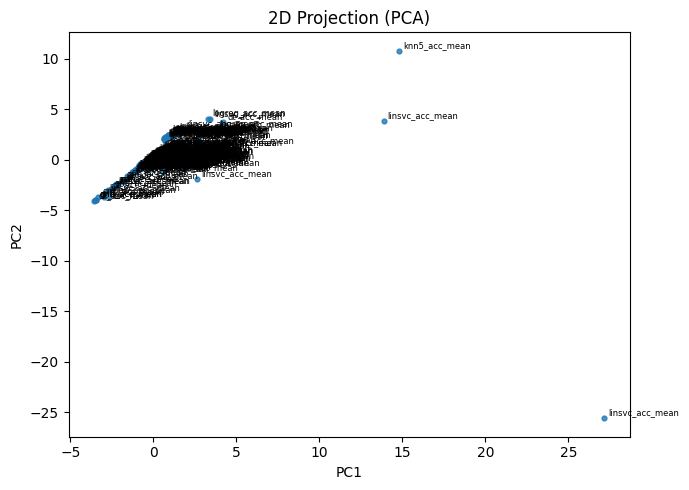

Saved to artifacts/meta_pca.png shape: (500, 2)


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


X_num = X_clean.apply(pd.to_numeric, errors='coerce')
X_num = X_num.replace([np.inf, -np.inf], np.nan)

pca_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(with_mean=True),
    PCA(n_components=2, random_state=0)
)

Z = pca_pipe.fit_transform(X_num)

labels = (
    meta_df.reindex(X_num.index)['meta_target_best_algo']
    .astype(str)
    .fillna('NA')
    .values
)

plt.figure(figsize=(7, 5))
plt.scatter(Z[:, 0], Z[:, 1], s=12, alpha=0.8)

for i, lbl in enumerate(labels):
    plt.annotate(lbl, (Z[i, 0], Z[i, 1]),
                 fontsize=6, xytext=(3, 2), textcoords='offset points')

plt.title('2D Projection (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.savefig('artifacts/meta_pca.png', dpi=160)
plt.show()
plt.close()

print('Saved to artifacts/meta_pca.png shape:', Z.shape)


### Обучение и сравнение мета-алгоритмов (включая наивный)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier

X_num = (
    X_clean.apply(pd.to_numeric, errors='coerce')     
          .replace([np.inf, -np.inf], np.nan)          # inf -> NaN
)


X_num = X_num.loc[:, X_num.notna().mean() > 0.05]
y_str = meta_df['meta_target_best_algo'].astype(str)
le = LabelEncoder()
y_enc = pd.Series(le.fit_transform(y_str), index=y_str.index, name='y')

X_num, y_enc = X_num.align(y_enc, join='inner', axis=0)
y_enc = y_enc.values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

models = {
    'naive_majority': DummyClassifier(strategy='most_frequent'),
    'rf': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('clf', RandomForestClassifier(n_estimators=400, random_state=0))
    ]),
    'gb': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('clf', GradientBoostingClassifier(random_state=0))
    ]),
    'hgb': HistGradientBoostingClassifier(random_state=0),  # NaN ok
}

for name, model in models.items():
    sc = cross_val_score(model, X_num, y_enc, cv=cv, scoring='accuracy', error_score='raise')
    print(name, sc.mean(), sc.std())


naive_majority 0.3 0.0
rf 0.524 0.05003998401278721
gb 0.504 0.03979949748426482
hgb 0.508 0.04874423042781575


### Абляция по группам признаков (без базовых / без статистических / без структурных)

In [10]:
def select_group(cols, group):
    if group=='basic':
        keys = ['n_samples','n_features','n_classes','frac_categorical','ratio_samples_per_feature']
    elif group=='stat':
        keys = [c for c in cols if c.startswith('col_')]
    elif group=='struct':
        keys = [c for c in cols if c.startswith('tree_')]
    else:
        keys=[]
    return keys

all_cols = [c for c in meta_df.columns if c not in ('did','name','meta_target_best_algo') and not c.endswith('_acc_mean')]
groups = {
    'without_basic': [c for c in all_cols if c not in select_group(all_cols,'basic')],
    'without_stat': [c for c in all_cols if c not in select_group(all_cols,'stat')],
    'without_struct': [c for c in all_cols if c not in select_group(all_cols,'struct')],
}

for label, cols in groups.items():
    Xg = meta_df[cols].astype(float)
    sc = cross_val_score(RandomForestClassifier(n_estimators=400, random_state=0), Xg, y_enc, cv=cv, scoring='accuracy')
    print(label, sc.mean(), sc.std())

without_basic 0.51 0.05621387729022077
without_stat 0.46799999999999997 0.04166533331199933
without_struct 0.522 0.07194442299441979


### Эксперимент с шумом на одном конкретном датасете

In [12]:
import numpy as np
import pandas as pd
import openml

# берем первый датасет из meta_df
did0 = int(meta_df['did'].iloc[0])
ds = openml.datasets.get_dataset(did0)
X, y, categorical, attr = ds.get_data(dataset_format='dataframe',
                                      target=ds.default_target_attribute)

# Добавим шум: перетасуем 10% меток и зашумим 10% числовых значений
rng = np.random.RandomState(0)

# 1) шум в таргете
y_noisy = y.copy()
if len(y_noisy) > 0:
    idx = rng.choice(len(y_noisy), size=max(1, int(0.1 * len(y_noisy))), replace=False)
    unique = pd.Series(y).dropna().unique()
    if len(unique) > 0:
        y_noisy.iloc[idx] = rng.choice(unique, size=len(idx))

# 2) шум в числовых фичах (заменим 10% значений на среднее по столбцу)
X_noisy = X.copy()
num = X_noisy.select_dtypes(include=[np.number]).copy()
if not num.empty:
    idx2 = (rng.rand(*num.shape) < 0.1)           # True там, где хотим зашумить
    col_means = num.mean()                        # Series по столбцам
    num = num.mask(idx2, other=col_means, axis=1) # <- ВАЖНО: axis=1 (выравнивание по столбцам)
    X_noisy[num.columns] = num

# считаем мета-признаки
m0 = compute_all_meta(X, y)
m1 = compute_all_meta(X_noisy, y_noisy)

# аккуратно достанем "лучший" алгоритм из лэндмарок
def pick_best(mdict):
    lm = {k: v for k, v in mdict.items() if k.endswith('_acc_mean') and np.isfinite(v)}
    return max(lm, key=lm.get) if lm else None

print('original best:', pick_best(m0))
print('noisy best:', pick_best(m1))

# сохраним для сравнения
pd.DataFrame([m0, m1], index=['original', 'noisy']).to_csv('noise_experiment_meta.csv', index=False)


C:\Users\edimv\AppData\Local\Temp\ipykernel_10568\823382480.py:46: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  return is_datetime64_any_dtype(obj) or _is_dt_tz(obj)
C:\Users\edimv\AppData\Local\Temp\ipykernel_10568\823382480.py:46: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  return is_datetime64_any_dtype(obj) or _is_dt_tz(obj)
C:\Users\edimv\AppData\Local\Temp\ipykernel_10568\823382480.py:46: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  return is_datetime64_any_dtype(obj) or _is_dt_tz(obj)
C:\Users\edimv\AppData\Local\Temp\ipykernel_10568\823382480.py:46: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isin

original best: dt_acc_mean
noisy best: logreg_acc_mean


### Визуализация оптимизации (Optuna/Hyperopt/Random Search/AutoML)

[I 2025-10-28 23:41:24,038] A new study created in memory with name: no-name-7928bfd2-31f8-4e3f-8543-914596ac32c5
[I 2025-10-28 23:41:26,068] Trial 0 finished with value: 0.49800000000000005 and parameters: {'n_estimators': 484, 'max_depth': 23, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.49800000000000005.
[I 2025-10-28 23:41:28,000] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 481, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.5.
[I 2025-10-28 23:41:29,578] Trial 2 finished with value: 0.488 and parameters: {'n_estimators': 406, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.5.
[I 2025-10-28 23:41:31,054] Trial 3 finished with value: 0.5159999999999999 and parameters: {'n_estimators': 368, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.5159999999999999.
[I 2025-10-28 23:41:33,123] Trial 4 finished with value: 0.514 and parameters: {'n_estimators': 498, 'max_depth': 28, 'min_sample

Best value: 0.542
Best params: {'n_estimators': 257, 'max_depth': 21, 'min_samples_leaf': 3}


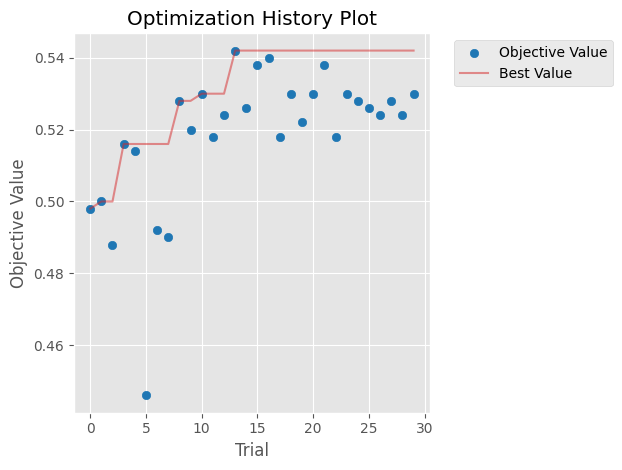

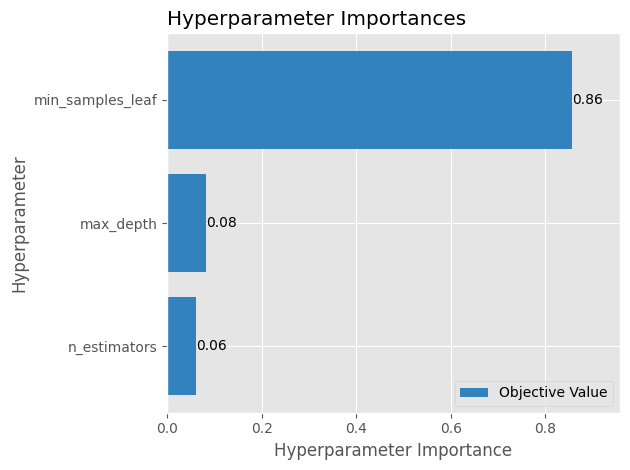

In [14]:
import numpy as np
import pandas as pd
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# --- данные X_clean / y_enc уже подготовлены (без NaN).
# На всякий случай можно убрать NaN, если остались:
# from sklearn.impute import SimpleImputer
# X_clean = SimpleImputer().fit_transform(X_clean)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def objective(trial):
    n_estimators    = trial.suggest_int('n_estimators', 100, 800)
    max_depth       = trial.suggest_int('max_depth', 3, 30)
    min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 10)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=0,
        n_jobs=-1
    )
    sc = cross_val_score(clf, X_clean, y_enc, cv=cv, scoring='accuracy')
    return sc.mean()

# Зафиксируем сид у TPE для воспроизводимости
from optuna.samplers import TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=0))
study.optimize(objective, n_trials=30)

print('Best value:', study.best_value)
print('Best params:', study.best_params)

# --- ВИЗУАЛИЗАЦИЯ БЕЗ plotly (matplotlib-версия)
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

ax1 = plot_optimization_history(study)
ax1.figure.tight_layout()
ax1.figure.savefig('optuna_optimization_history.png', dpi=160)

# Важности гиперпараметров могут быть не доступны на очень маленьком количестве испытаний — оборачиваем в try:
try:
    ax2 = plot_param_importances(study)
    ax2.figure.tight_layout()
    ax2.figure.savefig('optuna_param_importances.png', dpi=160)
except Exception as e:
    print("Param importances plot skipped:", e)
